# Assignment 5 - Supervised Learning

Jonathan Chia - jchia3 - due 10/01/2023

![Alt text](image.png)

In [1]:
# Key Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score

# 1. Load in the Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 2. Explore Data

## Visualizing

### PassengerID
PassengerId is probably useless

<Axes: >

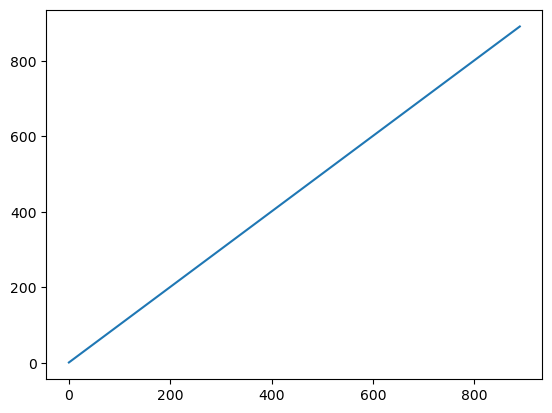

In [3]:
train.PassengerId.plot()

### Survived
Looks like this dataset is a bit imbalanced

<Axes: >

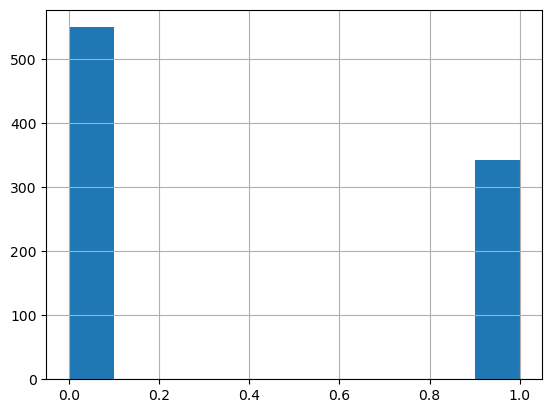

In [4]:
train.Survived.hist()

### Pclass and Fare
Pclass is distributed the same in train and test. Because this relates to economic status, I wouldn't be surprised if class 1 survived more

<Axes: >

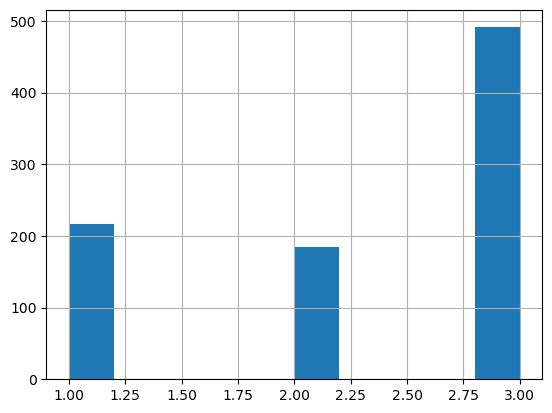

In [5]:
train.Pclass.hist()

<Axes: >

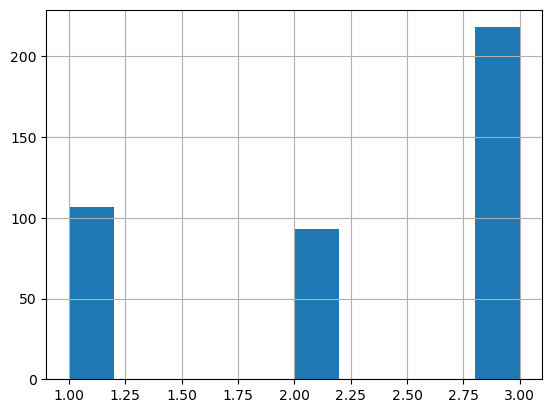

In [6]:
test.Pclass.hist()

Yup, more rich ones survived. We'll have to see how the other variables interact with being rich though. Like does Pclass = 1 have proportionally more females or kids? 

In [7]:
train.groupby('Pclass').Survived.value_counts()

Pclass  Survived
1       1           136
        0            80
2       0            97
        1            87
3       0           372
        1           119
Name: count, dtype: int64

Do higher pclass have higher fares?

In [8]:
train.groupby('Pclass').Fare.mean()

Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64

### Names
For names, I bet that being a married lady gives you higher chance of survival. Let's create a column for mrs.

In [9]:
train['MarriedLady'] = train.Name.str.contains(r'mrs\.', case=False)

In [10]:
# apply to test data as well
test['MarriedLady'] = test.Name.str.contains(r'mrs\.', case=False)

<Axes: xlabel='MarriedLady'>

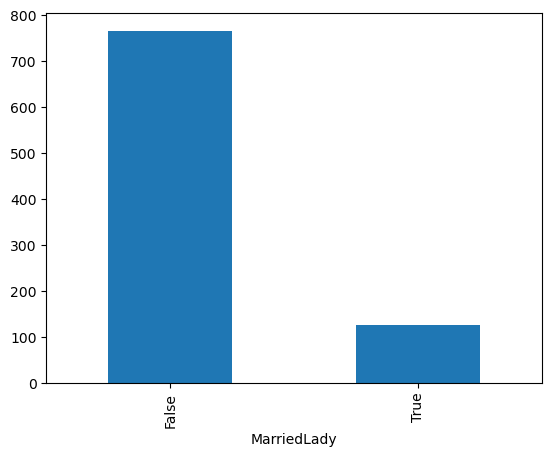

In [11]:
train.MarriedLady.value_counts().plot(kind='bar')

How many married ladies survived?

In [12]:
train.groupby('MarriedLady').Survived.value_counts()

MarriedLady  Survived
False        0           523
             1           243
True         1            99
             0            26
Name: count, dtype: int64

### Age and Sex

In [13]:
train.Sex.value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

<Axes: >

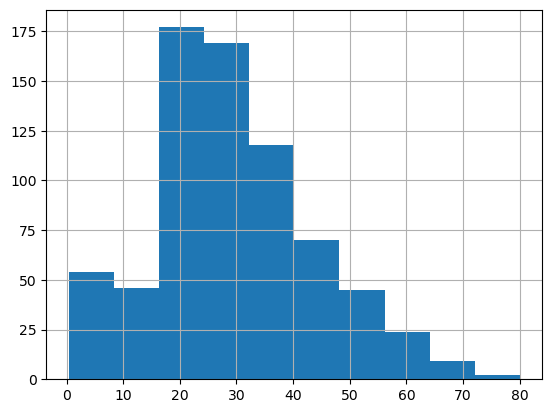

In [14]:
train.Age.hist()

<Axes: xlabel='Age', ylabel='Survived'>

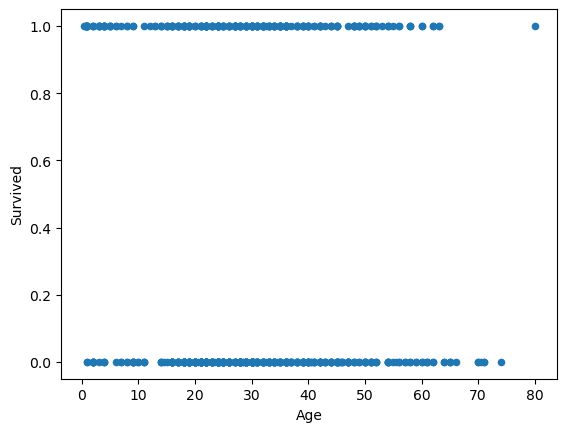

In [15]:
train[['Age', 'Survived']].plot(kind='scatter', x='Age', y='Survived')

### Siblings/Spouses

<Axes: >

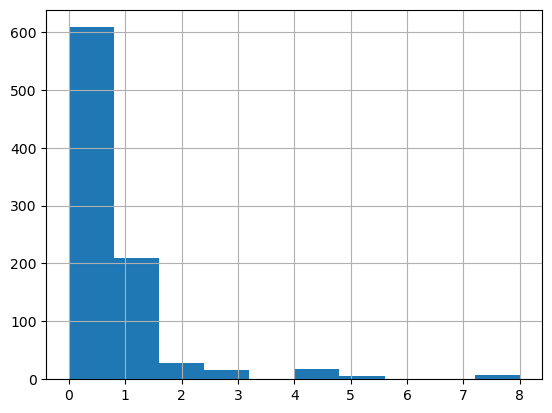

In [16]:
train.SibSp.hist()

### Parch

<Axes: >

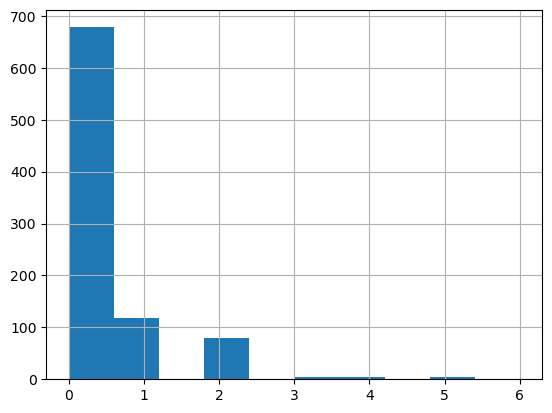

In [17]:
train.Parch.hist()

### Does ticket number give us any additional info?

In [18]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,MarriedLady
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,False
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,False
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,False
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,False
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,False


Hmmm. Let's come back to this maybe later?

### Cabin

In [19]:
train.groupby('Cabin').Survived.sum().sort_values(ascending=False)[0:10]

Cabin
B96 B98        4
E101           3
F33            3
C23 C25 C27    2
C52            2
D20            2
E8             2
B35            2
D17            2
D              2
Name: Survived, dtype: int64

There's so many different cabins it is hard to say

In [20]:
train['HasCabin'] = train['Cabin'].notna().astype(int)

In [21]:
train.groupby('HasCabin').Survived.sum()

HasCabin
0    206
1    136
Name: Survived, dtype: int64

What about by letters?

In [22]:
train['CabinLetter'] = train.Cabin.str[0]

In [23]:
test['CabinLetter'] = test.Cabin.str[0].fillna('Q')

Ahh now that is more useful

In [24]:
train.groupby('CabinLetter').Survived.sum()

CabinLetter
A     7
B    35
C    35
D    25
E    24
F     8
G     2
T     0
Name: Survived, dtype: int64

In [25]:
train.CabinLetter.fillna('Q', inplace=True)

In [26]:
train.groupby('CabinLetter').Survived.sum()

CabinLetter
A      7
B     35
C     35
D     25
E     24
F      8
G      2
Q    206
T      0
Name: Survived, dtype: int64

Could the cabin number be more important though? like maybe more people on the front of the boat survived and that would be the lower numbers

In [27]:
train['CabinNumbers'] = train.Cabin.str.extract('(\d+)').fillna('150').astype(int)

In [28]:
bins = pd.cut(train['CabinNumbers'], bins=10)

# Add the 'Bucket' column to the DataFrame
train['CabinNumberBin'] = bins

In [29]:
train.groupby('CabinNumberBin').Survived.sum()

CabinNumberBin
(1.852, 16.8]      23
(16.8, 31.6]       26
(31.6, 46.4]       25
(46.4, 61.2]       17
(61.2, 76.0]        9
(76.0, 90.8]        9
(90.8, 105.6]      16
(105.6, 120.4]      1
(120.4, 135.2]      7
(135.2, 150.0]    209
Name: Survived, dtype: int64

I think we'll stick with cabin letters for now

### Embarked

Cherbourg might be more rich? 

In [30]:
train.groupby('Embarked').Survived.mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

## Missing data?

In [31]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,HasCabin,CabinNumbers
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.228956,127.663300
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.420397,44.786773
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000,150.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000,150.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,0.000000,150.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,150.000000


Looks like we have some missing ages

For now, we can use like mean or median imputation, but I think later we can be smarter by giving different imputation based on name. 

For example, if there is a Mrs. without an age, we can assume she's likely older.

## Missing Categorical?

In [32]:
train.isna().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age               177
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin             687
Embarked            2
MarriedLady         0
HasCabin            0
CabinLetter         0
CabinNumbers        0
CabinNumberBin      0
dtype: int64

## Correlation

In [33]:
train[['Survived', 'Age', 'Fare', 'SibSp', 'Parch']].corr()

,Survived,Age,Fare,SibSp,Parch
Survived,1.000000,-0.077221,0.257307,-0.035322,0.081629
Age,-0.077221,1.000000,0.096067,-0.308247,-0.189119
Fare,0.257307,0.096067,1.000000,0.159651,0.216225
SibSp,-0.035322,-0.308247,0.159651,1.000000,0.414838
Parch,0.081629,-0.189119,0.216225,0.414838,1.000000


## Preprocessing

In [34]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,MarriedLady,HasCabin,CabinLetter,CabinNumbers,CabinNumberBin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,0,Q,150,"(135.2, 150.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True,1,C,85,"(76.0, 90.8]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,0,Q,150,"(135.2, 150.0]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True,1,C,123,"(120.4, 135.2]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False,0,Q,150,"(135.2, 150.0]"


In [35]:
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass'] #Pclass might be nominal but it's ordinal so idk
categorical_features = ['Sex', 'Embarked', 'CabinLetter', 'MarriedLady'] # i will use CabinLetter

features = numeric_features + categorical_features

In [36]:
X = train[features]
y = train.Survived

In [37]:
numerical_minmax_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('min_max', MinMaxScaler())
])

numerical_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('standard_scale', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # one hot encoding
])

preprocessor_standard = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

preprocessor_minmax = ColumnTransformer(
    transformers=[
        ('num', numerical_minmax_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Modeling

## Compare multiple baseline models using cross-validation on training set

In [38]:
def compare_models(_X, _y, _pipelines: dict): 
    names, scores = [], []
    for name, pipeline in _pipelines.items():
        fold_scores = cross_val_score(pipeline, _X, _y,
                                        cv=5,
                                        scoring='accuracy')
        scores.append(np.mean(fold_scores))
        names.append(name)

    return pd.DataFrame({'Model': names, 'Accuracy': scores})
        

Create dictionary of different model pipelines

In [39]:
nb_model = GaussianNB()
rf_model = RandomForestClassifier(random_state=0)
nn_model = MLPClassifier(random_state=0)
svc_model = SVC(class_weight='balanced', kernel='linear', C=2)
svc_rbf_model = SVC(class_weight='balanced', kernel='rbf', C=2)

nb_pipeline = Pipeline(steps=[('preprocessor', preprocessor_standard),
                              ('model', nb_model)])

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor_minmax),
                              ('model', rf_model)])

nn_pipeline = Pipeline(steps=[('preprocessor', preprocessor_minmax),
                              ('model', nn_model)])

svc_pipeline = Pipeline(steps=[('preprocessor', preprocessor_minmax),
                              ('model', svc_model)])

svc_rbf_pipeline = Pipeline(steps=[('preprocessor', preprocessor_minmax),
                              ('model', svc_rbf_model)])

pipeline_dict = {'naive bayes': nb_pipeline,
                 'random forest': rf_pipeline,
                 'neural network': nn_pipeline,
                 'svc (linear)': svc_pipeline,
                 'svc (rbf)': svc_rbf_pipeline}

In [40]:
results_df = compare_models(X, y, pipeline_dict)

c:\Users\jonat\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jonat\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


c:\Users\jonat\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jonat\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jonat\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [41]:
results_df

,Model,Accuracy
0,naive bayes,0.731806
1,random forest,0.803609
2,neural network,0.813715
3,svc (linear),0.772161
4,svc (rbf),0.785657


## Compare hyperparameter-tuned models using grid search cv

In [42]:
def compare_tuned_models(_X, _y, _model_df: pd.DataFrame): 
    names, scores, grid_searches = [], [], []
    for index, row in _model_df.iterrows():
        gs = GridSearchCV(estimator=row['pipeline'], param_grid=row['param_grid'], scoring='accuracy', cv=5)
        gs.fit(_X, _y)
        scores.append(gs.best_score_)
        names.append(row['name'])
        grid_searches.append(gs)

    return pd.DataFrame({'Model': names, 'Accuracy': scores, 'GS': grid_searches})

In [43]:
rf_model = RandomForestClassifier(random_state=0, n_jobs=-1)
nn_model = MLPClassifier(random_state=0)
svc_model = SVC(class_weight='balanced', kernel='linear', C=2)
svc_rbf_model = SVC(class_weight='balanced', kernel='rbf', C=2)

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor_minmax),
                              ('model', rf_model)])

nn_pipeline = Pipeline(steps=[('preprocessor', preprocessor_minmax),
                              ('model', nn_model)])

svc_pipeline = Pipeline(steps=[('preprocessor', preprocessor_minmax),
                              ('model', svc_model)])

svc_rbf_pipeline = Pipeline(steps=[('preprocessor', preprocessor_minmax),
                              ('model', svc_rbf_model)])

param_grid_random_forest = {
    'model__n_estimators': [50, 100, 200], # number of trees
    'model__max_depth': [None, 10, 20, 30], # max depth of each tree
    'model__min_samples_split': [2, 5, 10], # when to split nodes 
    'model__min_samples_leaf': [1, 2, 4], # minimum samples in each leaf
    'model__bootstrap': [True, False] # bootstrap sampling
}

param_grid_nn = {
    'model__hidden_layer_sizes': [(100,), (50, 50), (100, 50, 25)],
    'model__activation': ['relu'], # relu is probably good enough
    'model__alpha': [0.0001, 0.001, 0.01], # amount of L2 regularization (helps with overfitting)
    'model__solver': ['adam'], # general best solver
    'model__max_iter': [100, 200, 300], # how long to train
    'model__early_stopping': [True, False] # helps with overfitting
}

param_grid_svc = {
    'model__C': [0.1, 1, 10], # regularization
    'model__kernel': ['linear']
}

param_grid_svc_rbf = {
    'model__C': [0.1, 1, 10], # regularization
    'model__kernel': ['rbf'],
    'model__gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1] # coefficient in the rbf kernel
}

name = ['random forest', 'neural network', 'svc (linear)', 'svc (rbf)']
pipeline = [rf_pipeline, nn_pipeline, svc_pipeline, svc_rbf_pipeline]
param_grid = [param_grid_random_forest, param_grid_nn, param_grid_svc, param_grid_svc_rbf] 

model_df = pd.DataFrame({'name': name, 
                         'pipeline': pipeline, 
                         'param_grid': param_grid})

model_df

,name,pipeline,param_grid
0,random forest,"(ColumnTransformer(transformers=[('num',\n ...","{'model__n_estimators': [50, 100, 200], 'model..."
1,neural network,"(ColumnTransformer(transformers=[('num',\n ...","{'model__hidden_layer_sizes': [(100,), (50, 50..."
2,svc (linear),"(ColumnTransformer(transformers=[('num',\n ...","{'model__C': [0.1, 1, 10], 'model__kernel': ['..."
3,svc (rbf),"(ColumnTransformer(transformers=[('num',\n ...","{'model__C': [0.1, 1, 10], 'model__kernel': ['..."


In [44]:
%%time
tuned_results_df = compare_tuned_models(X, y, model_df)

c:\Users\jonat\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jonat\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jonat\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jonat\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jonat\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

CPU times: total: 5min 54s
Wall time: 4min 45s


In [45]:
tuned_results_df

,Model,Accuracy,GS
0,random forest,0.830532,"GridSearchCV(cv=5,\n estimator=Pip..."
1,neural network,0.826094,"GridSearchCV(cv=5,\n estimator=Pip..."
2,svc (linear),0.776656,"GridSearchCV(cv=5,\n estimator=Pip..."
3,svc (rbf),0.799121,"GridSearchCV(cv=5,\n estimator=Pip..."


Wow looks like random forest is the best! I could also try a boosted tree algorithm like XGBoost or Catboost, but I imagine it would be just a little better

## Use Best Model to Make Predictions

In [46]:
feature_importances = tuned_results_df.loc[0].GS.best_estimator_.named_steps['model'].feature_importances_

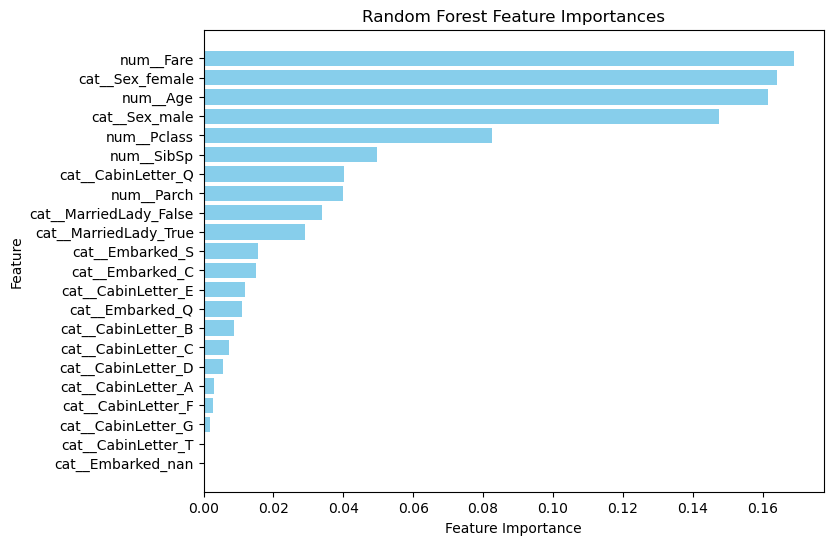

In [47]:
importance_df = pd.DataFrame({'Feature': tuned_results_df.loc[0].GS.best_estimator_.named_steps['preprocessor'].get_feature_names_out(), 'Importance': feature_importances})

# Sort the DataFrame by importance values (optional)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()  # Invert the y-axis for better visualization (optional)
plt.show()

![Alt text](image-1.png)

![Alt text](image-2.png)

In [48]:
y_pred = tuned_results_df.loc[0].GS.best_estimator_.predict(test)

In [49]:
def save_preds(_fn, _y_pred, _df):
    import csv
    with open(_fn, 'w') as fout:
        writer = csv.writer(fout, delimiter=',', lineterminator='\n')
        writer.writerow(['PassengerId', 'Survived'])
        for yid, ypred in zip(_df['PassengerId'], _y_pred):
            writer.writerow([yid, ypred])

save_preds('predictions_chia.csv', y_pred, test)

![Alt text](image-3.png)

Dang, didn't beat Dr. Erhan haha.

Things to improve on:

1. Improve the feature engineering. See this link: https://www.kaggle.com/code/yernarakhmetbek/titanic-advanced-feature-engineering-tutorial
    - add binning - it will help with outliers
    - improve titles - there's doctors and some other titles in there
    - combine parch and sib/sp to get family size and then bin it
    - be smarter about age imputation
    - ticket groups

Here is the random forest importance from the link above:

![Alt text](image-4.png)

2. Fit the final model on the full dataset and then submit predictions and see if that helps

Key Learnings:

I should be spending like 90% of my time on feature engineering

## Improving Feature Engineering

### Ticket Frequency

In [50]:
train['TicketFrequency'] = train.groupby('Ticket').Ticket.transform('count')

In [51]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,MarriedLady,HasCabin,CabinLetter,CabinNumbers,CabinNumberBin,TicketFrequency
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,0,Q,150,"(135.2, 150.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True,1,C,85,"(76.0, 90.8]",1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,0,Q,150,"(135.2, 150.0]",1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True,1,C,123,"(120.4, 135.2]",2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False,0,Q,150,"(135.2, 150.0]",1


In [52]:
# apply to test as well
test['TicketFrequency'] = test.groupby('Ticket').Ticket.transform('count')

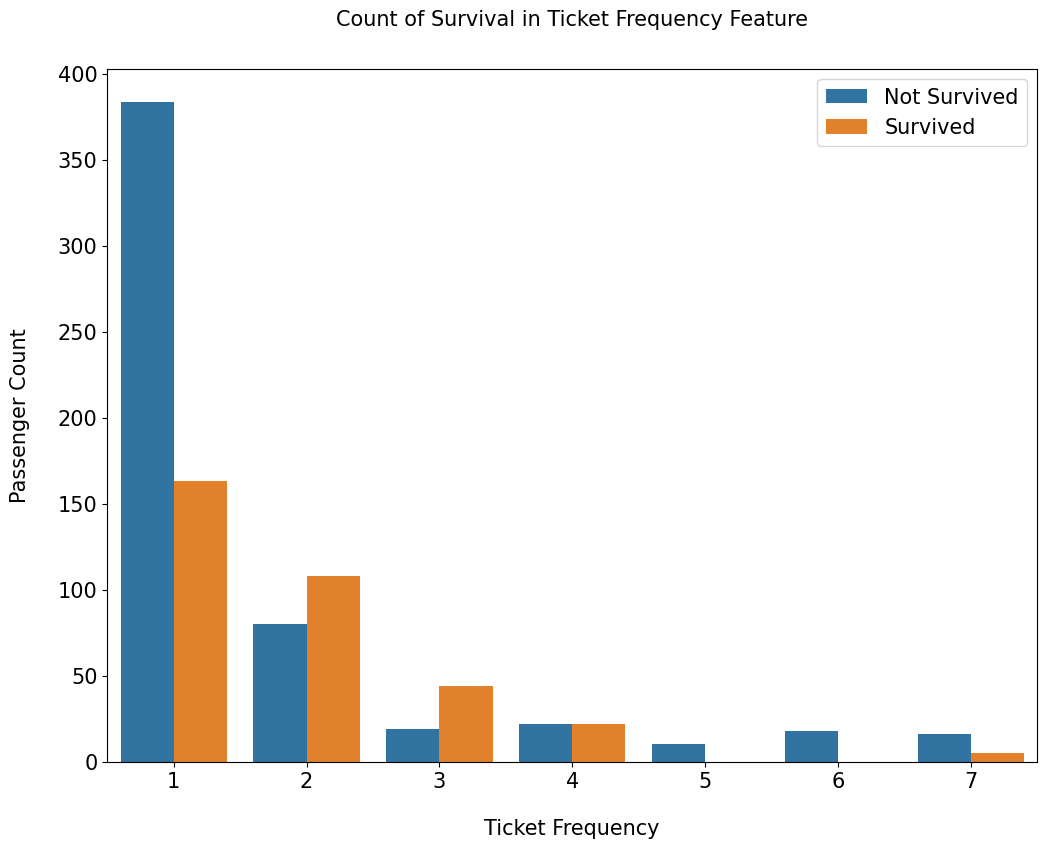

In [53]:
import seaborn as sns

fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='TicketFrequency', hue='Survived', data=train)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

## Family Size

In [54]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

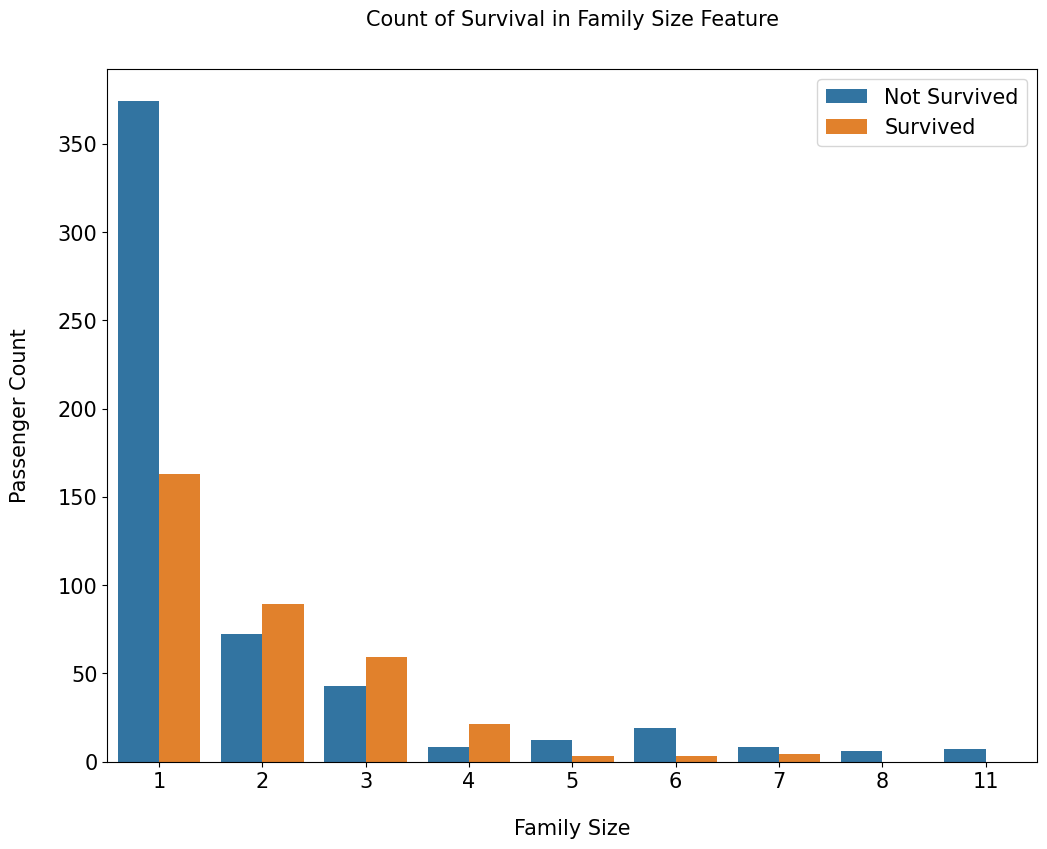

In [55]:
fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='FamilySize', hue='Survived', data=train)

plt.xlabel('Family Size', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Family Size'), size=15, y=1.05)

plt.show()

### Title

In [56]:
train['Title'] = train['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
test['Title'] = test['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

In [57]:
train['Title'] = train['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
train['Title'] = train['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

test['Title'] = test['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
test['Title'] = test['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

In [58]:
train.Title.value_counts()

Title
Mr                          517
Miss/Mrs/Ms                 313
Master                       40
Dr/Military/Noble/Clergy     21
Name: count, dtype: int64

## Fit new model and submit predictions

In [59]:
numeric_features = ['Age', 'Fare', 'Pclass', 'TicketFrequency', 'FamilySize'] #Pclass might be nominal but it's ordinal so idk
categorical_features = ['Sex', 'Embarked', 'CabinLetter', 'MarriedLady', 'Title'] # i will use CabinLetter

features = numeric_features + categorical_features

In [60]:
X = train[features]
y = train.Survived

In [61]:
preprocessor_minmax = ColumnTransformer(
    transformers=[
        ('num', numerical_minmax_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [62]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor_minmax),
                              ('model', rf_model)])

In [63]:
gs = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid_random_forest, scoring='accuracy', cv=5)
gs.fit(X, y)

y_pred = gs.predict(test)

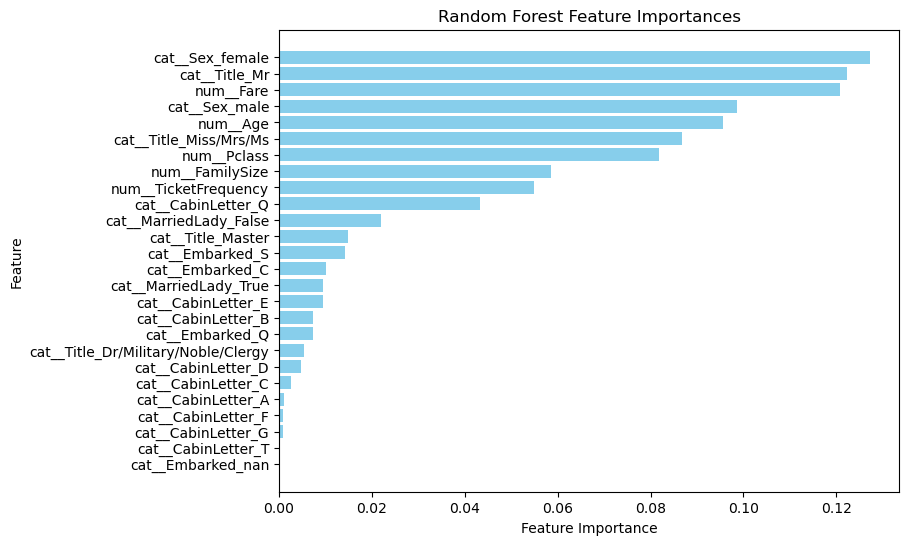

In [64]:
feature_importances = gs.best_estimator_.named_steps['model'].feature_importances_
importance_df = pd.DataFrame({'Feature': gs.best_estimator_.named_steps['preprocessor'].get_feature_names_out(), 'Importance': feature_importances})

# Sort the DataFrame by importance values (optional)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()  # Invert the y-axis for better visualization (optional)
plt.show()

In [65]:
def save_preds(_fn, _y_pred, _df):
    import csv
    with open(_fn, 'w') as fout:
        writer = csv.writer(fout, delimiter=',', lineterminator='\n')
        writer.writerow(['PassengerId', 'Survived'])
        for yid, ypred in zip(_df['PassengerId'], _y_pred):
            writer.writerow([yid, ypred])

save_preds('predictions_chia.csv', y_pred, test)

![Alt text](image-5.png)

Dang I thought that would improve my predictions more.

If I were to continue, I would do better age imputation, and bin my numeric variables next. 

Let's try fitting on the entire training dataset and then submitting predictions

In [66]:
best_params = gs.best_params_

In [67]:
best_params

{'model__bootstrap': True,
 'model__max_depth': None,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 10,
 'model__n_estimators': 100}

In [68]:
final_rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor_minmax),
                              ('model', RandomForestClassifier(random_state=0, n_jobs=-1, bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100))])

In [69]:
final_rf_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('min_max',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Fare', 'Pclass',
                                                   'TicketFrequency',
                                                   'FamilySize']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked',
                                                   'CabinLetter', 'MarriedLady',
                                                   'Title'])])),
                ('model',
                 RandomForestClassifier(min_samples_leaf=2,
                                        min_samples_split=10, n_jobs=-1,
                                        random_state=0))])

In [70]:
y_pred = final_rf_pipeline.predict(test)

In [71]:
def save_preds(_fn, _y_pred, _df):
    import csv
    with open(_fn, 'w') as fout:
        writer = csv.writer(fout, delimiter=',', lineterminator='\n')
        writer.writerow(['PassengerId', 'Survived'])
        for yid, ypred in zip(_df['PassengerId'], _y_pred):
            writer.writerow([yid, ypred])

save_preds('predictions_chia.csv', y_pred, test)

That didn't improve the score, sadly